In [1]:
!pip install qiskit==0.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit import Aer
from qiskit.aqua.components.feature_maps import SecondOrderExpansion,FirstOrderExpansion
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua import QuantumInstance
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/usr/local/lib/python3.8/dist-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
/usr/local/lib/python3.8

In [3]:
def breast_cancer(training_size, test_size, n, plot_data=False):
    """ returns breast cancer dataset """
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(return_X_y=True)
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise NameError('Matplotlib not installed. Please install it before plotting')
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

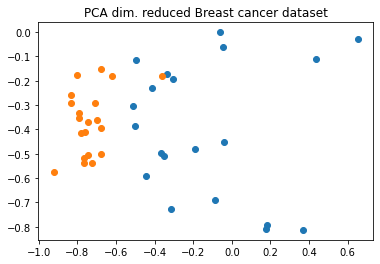

In [4]:

feature_dim = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=feature_dim,
    plot_data=True
)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

In [6]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

/usr/local/lib/python3.8/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py:82: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.astype(np.float)


Testing success ratio: 0.85


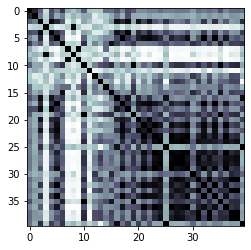

In [7]:
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')

/usr/local/lib/python3.8/dist-packages/qiskit/aqua/algorithms/classifiers/sklearn_svm/_sklearn_svm_binary.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.astype(np.float)
/usr/local/lib/python3.8/dist-packages/qiskit/aqua/algorithms/classifiers/sklearn_svm/_sklearn_svm_binary.py:99: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informat

Testing success ratio: 0.85


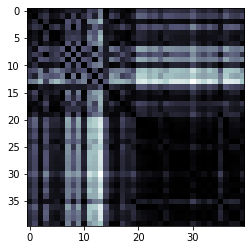

In [8]:
from qiskit.aqua.algorithms import SklearnSVM
result = SklearnSVM(training_input, test_input).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');